# Compare EEA-S5P L2 data

In [5]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

# Data Standarization

### Import Copernicus Air Data (Refer to Process_S5P.ipynb)

In [6]:
copernicus_data = pd.read_csv('all_copernicus_air_quality.csv')
copernicus_data = copernicus_data.rename(columns = {'station': 'sensorID', 'value': 'copernicus_CO', 'date': 'day'})
copernicus_data['timestamp'] = pd.to_datetime(copernicus_data['timestamp'])
copernicus_data['hour'] = copernicus_data['timestamp'].dt.ceil('H').dt.hour.astype(int)
copernicus_data['copernicus_CO'] = copernicus_data['copernicus_CO']*28 #Convert to grams per m^2
copernicus_data.head()

,day,timestamp,sensorID,copernicus_CO,hour
0,2025-05-22,2025-05-22 00:47:02,SPO-EE0018A_00010_100,NaN,1
1,2025-05-22,2025-05-22 00:47:02,SPO-DK0045A_00010_100,NaN,1
2,2025-05-22,2025-05-22 02:27:02,GB_SamplingPoint_205,NaN,3
3,2025-05-22,2025-05-22 02:27:02,GB_SamplingPoint_112,NaN,3
4,2025-05-22,2025-05-22 02:27:02,SPO-LU0101A_00010_100,NaN,3


### Import Copernicus Air Data (Refer to EEA-API)

In [7]:
sensors_data = pd.read_csv('valid_sensors_data.csv').drop('Unnamed: 0', axis=1)
sensors_data = sensors_data.rename(columns = {'station': 'sensorID', 'Value': 'sensor_CO'})
sensors_data['End'] = pd.to_datetime(sensors_data['End'])
sensors_data['End'] = sensors_data['End'].dt.tz_localize(None)
sensors_data['hour'] = sensors_data['hour'].fillna(-1).astype(int)
sensors_data.head()

,sensorID,country,city,day,hour,sensor_CO,End
0,SPO-FR04055_10,FR,Paris (greater city),2025-05-22,2,0.129,2025-05-22 01:00:00
1,SPO-FR04055_10,FR,Paris (greater city),2025-05-22,3,0.115,2025-05-22 02:00:00
2,SPO-FR04055_10,FR,Paris (greater city),2025-05-22,4,0.108,2025-05-22 03:00:00
3,SPO-FR04055_10,FR,Paris (greater city),2025-05-22,5,0.109,2025-05-22 04:00:00
4,SPO-FR04055_10,FR,Paris (greater city),2025-05-22,6,0.116,2025-05-22 05:00:00


### Merge Data

In [8]:
merged_data = copernicus_data.merge(
    sensors_data[['day', 'hour', 'sensorID', 'sensor_CO']],
    on=['day', 'hour', 'sensorID'],
    how='left'
)
merged_data.head()

merged_data = merged_data.sort_values(by=['sensorID', 'timestamp'])
merged_data.head()

,day,timestamp,sensorID,copernicus_CO,hour,sensor_CO
890,2025-05-20,2025-05-20 12:57:02,GB_SamplingPoint_107,0.748000,13,NaN
5,2025-05-22,2025-05-22 02:27:02,GB_SamplingPoint_107,NaN,3,0.11642
11,2025-05-22,2025-05-22 02:32:02,GB_SamplingPoint_107,NaN,3,0.11642
25,2025-05-22,2025-05-22 13:59:09,GB_SamplingPoint_107,0.832713,14,0.11642
33,2025-05-23,2025-05-23 02:09:09,GB_SamplingPoint_107,NaN,3,0.11642


### Interpolate for further visualization

In [9]:
# Interpolate 'copernicus_CO' for each sensorID using both 'timestamp' (day+time) as x values
def interpolate_with_time(df, group_col, x_col, y_col, new_col):
    def interp_func(group):
        mask = group[y_col].notna()
        if mask.sum() < 2:
            return group[y_col]  # Not enough points to interpolate
        x = group.loc[mask, x_col].astype(np.int64)  # convert datetime to int
        y = group.loc[mask, y_col]
        x_full = group[x_col].astype(np.int64)
        y_interp = np.interp(x_full, x, y)
        y_interp[~mask.values] = y_interp[~mask.values]
        return pd.Series(y_interp, index=group.index)
    df[new_col] = df.groupby(group_col, group_keys=False).apply(
        lambda g: interp_func(g)
    )
    return df

merged_data = interpolate_with_time(
    merged_data,
    group_col='sensorID',
    x_col='timestamp',
    y_col='copernicus_CO',
    new_col='interp_copernicus_CO'
)

### Recall valid sampling points

In [10]:
valid_sampling_data = pd.read_csv('coordinates_valid_sampling_pts.csv')
valid_sampling_data = valid_sampling_data[valid_sampling_data['download_success']]
valid_sampling_data

,Sampling station ID,Lon,Lat,country,city,download_success
0,GB_SamplingPoint_107,-3.17625,51.48178,GB,Cardiff,True
1,GB_SamplingPoint_112,-5.92883,54.59965,GB,Greater Belfast,True
2,GB_SamplingPoint_127,-1.54647,53.80378,GB,Leeds,True
3,GB_SamplingPoint_205,-0.21349,51.52105,GB,London (greater city),True
4,GB_SamplingPoint_61573,-3.18219,55.94559,GB,City of Edinburgh,True
14,SPO-CH0005A_00010_502,8.61340,47.40290,CH,Zürich (greater city),True
15,SPO-CH0010A_00010_500,8.53041,47.37760,CH,Zürich (greater city),True
16,SPO-DK0045A_00010_100,12.56140,55.70028,DK,København,True
17,SPO-EE0018A_00010_100,24.64946,59.41417,EE,Tallinn,True
18,SPO-FR03043_10,5.39472,43.30529,FR,Marseille,True


In [11]:
', '.join(valid_sampling_data.city.unique())

'Cardiff, Greater Belfast, Leeds, London (greater city), City of Edinburgh, Zürich (greater city), København, Tallinn, Marseille, Paris (greater city), Athina, Luxembourg, Lisboa (greater city), Barcelona, A Coruña, Madrid, Cartagena'

In [12]:
valid_sampling_data

,Sampling station ID,Lon,Lat,country,city,download_success
0,GB_SamplingPoint_107,-3.17625,51.48178,GB,Cardiff,True
1,GB_SamplingPoint_112,-5.92883,54.59965,GB,Greater Belfast,True
2,GB_SamplingPoint_127,-1.54647,53.80378,GB,Leeds,True
3,GB_SamplingPoint_205,-0.21349,51.52105,GB,London (greater city),True
4,GB_SamplingPoint_61573,-3.18219,55.94559,GB,City of Edinburgh,True
14,SPO-CH0005A_00010_502,8.61340,47.40290,CH,Zürich (greater city),True
15,SPO-CH0010A_00010_500,8.53041,47.37760,CH,Zürich (greater city),True
16,SPO-DK0045A_00010_100,12.56140,55.70028,DK,København,True
17,SPO-EE0018A_00010_100,24.64946,59.41417,EE,Tallinn,True
18,SPO-FR03043_10,5.39472,43.30529,FR,Marseille,True


## Visualize Correlations

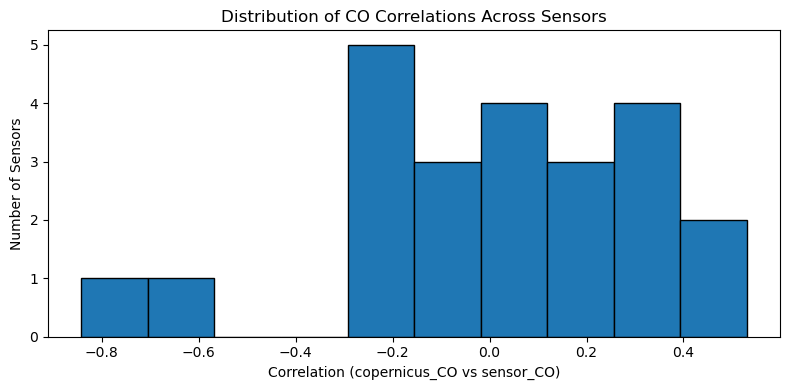

,sensorID,level_1,correlation
18,SP_08019057_6_48,copernicus_CO,0.530541
10,SPO-FR04055_10,copernicus_CO,0.487592
20,SP_08169009_6_48,copernicus_CO,0.392807
9,SPO-FR03043_10,copernicus_CO,0.315743
1,GB_SamplingPoint_112,copernicus_CO,0.315317
21,SP_08301004_6_48,copernicus_CO,0.287547
7,SPO-DK0045A_00010_100,copernicus_CO,0.185882
25,SP_30016020_6_48,copernicus_CO,0.138506
23,SP_28079035_6_48,copernicus_CO,0.127402
13,SPO-LU0101A_00010_100,copernicus_CO,0.111911


In [13]:
correlation_df = merged_data[['timestamp', 'sensorID', 'copernicus_CO', 'sensor_CO']]
correlation_df = correlation_df.sort_values(by=['sensorID','timestamp'])

# Calculate correlation for each sensorID
sensor_correlations = (
    correlation_df
    .dropna(subset=['copernicus_CO', 'sensor_CO'])
    .groupby('sensorID')[['copernicus_CO', 'sensor_CO']]
    .corr().iloc[0::2, -1]
    .reset_index()
    .rename(columns={'sensor_CO': 'correlation'})
)

sensor_correlations = sensor_correlations.sort_values(by='correlation', ascending=False)

# Plot histogram
fig, ax = plt.subplots(figsize=(8, 4))  #
plt.hist(sensor_correlations['correlation'].dropna()[:], bins=10, edgecolor='black')
plt.xlabel('Correlation (copernicus_CO vs sensor_CO)')
plt.ylabel('Number of Sensors')
plt.title('Distribution of CO Correlations Across Sensors')
plt.tight_layout()
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.grid(False)
plt.tight_layout()
plt.show()

sensor_correlations

## Overview of Data

In [14]:
pd.merge(
    sensor_correlations,
    valid_sampling_data,
    left_on='sensorID',
    right_on='Sampling station ID'
).head()

,sensorID,level_1,correlation,Sampling station ID,Lon,Lat,country,city,download_success
0,SP_08019057_6_48,copernicus_CO,0.530541,SP_08019057_6_48,2.11510,41.38750,ES,Barcelona,True
1,SPO-FR04055_10,copernicus_CO,0.487592,SPO-FR04055_10,2.34462,48.86212,FR,Paris (greater city),True
2,SP_08169009_6_48,copernicus_CO,0.392807,SP_08169009_6_48,2.08214,41.32177,ES,Barcelona,True
3,SPO-FR03043_10,copernicus_CO,0.315743,SPO-FR03043_10,5.39472,43.30529,FR,Marseille,True
4,GB_SamplingPoint_112,copernicus_CO,0.315317,GB_SamplingPoint_112,-5.92883,54.59965,GB,Greater Belfast,True


In [15]:
#convert g to mg
merged_data[['copernicus_CO', 'interp_copernicus_CO']] = merged_data[['copernicus_CO', 'interp_copernicus_CO']]*1000000 

SP_08019057_6_48, 18    0.530541
Name: correlation, dtype: float64


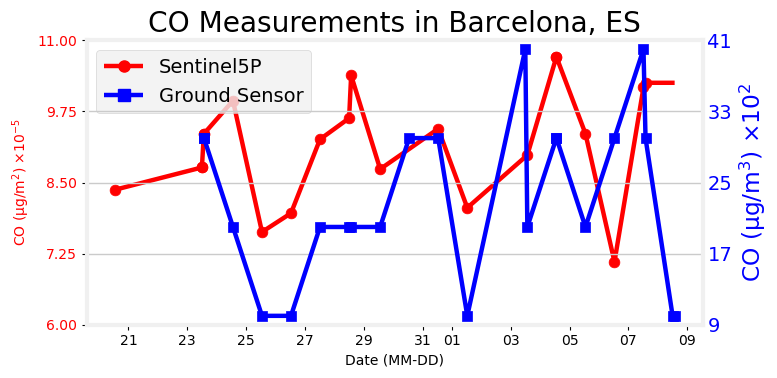

SPO-FR04055_10, 10    0.487592
Name: correlation, dtype: float64


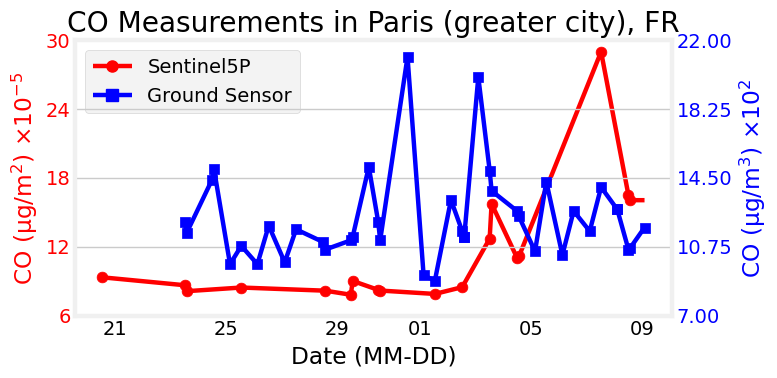

SP_08169009_6_48, 20    0.392807
Name: correlation, dtype: float64


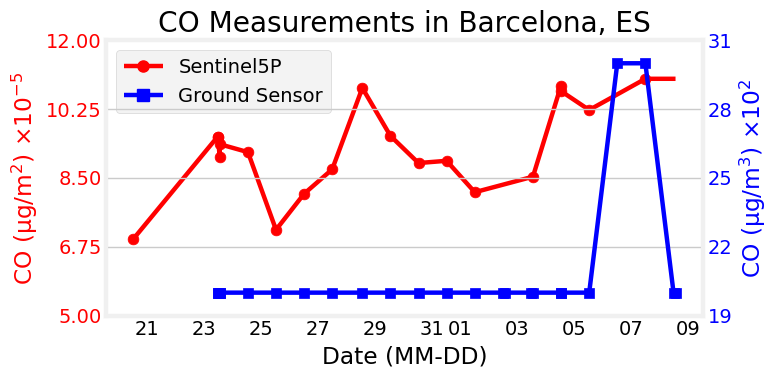

SPO-FR03043_10, 9    0.315743
Name: correlation, dtype: float64


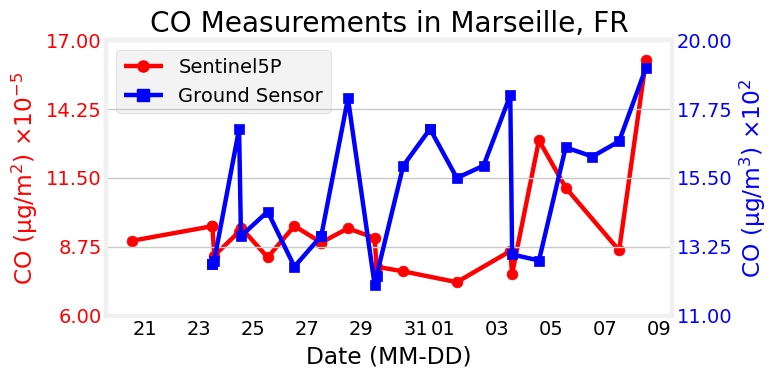

GB_SamplingPoint_112, 1    0.315317
Name: correlation, dtype: float64


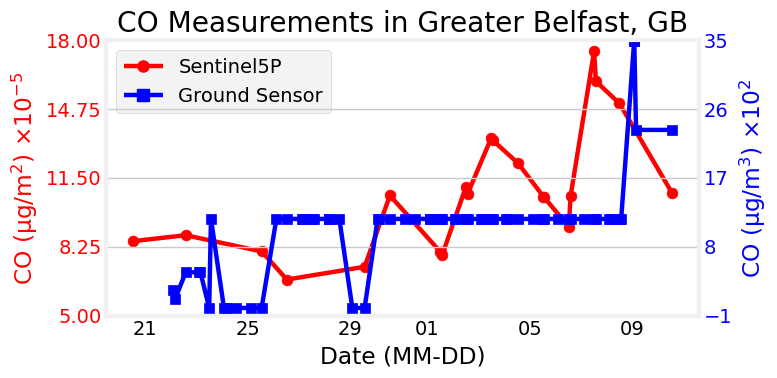

SP_08301004_6_48, 21    0.287547
Name: correlation, dtype: float64


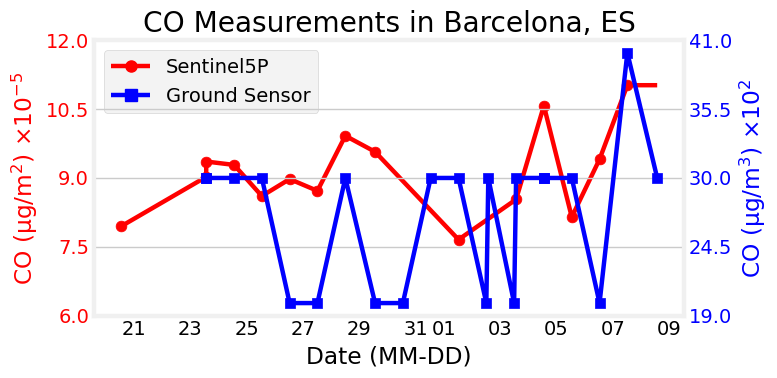

SPO-DK0045A_00010_100, 7    0.185882
Name: correlation, dtype: float64


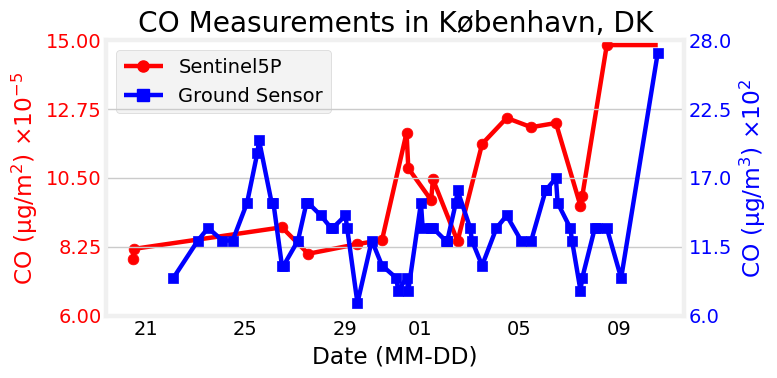

SP_30016020_6_48, 25    0.138506
Name: correlation, dtype: float64


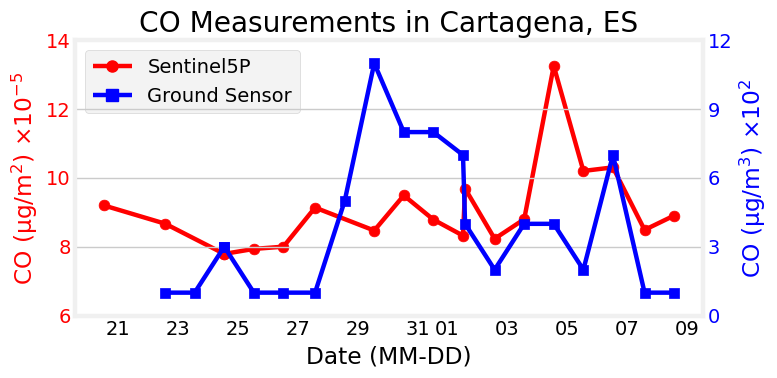

SP_28079035_6_48, 23    0.127402
Name: correlation, dtype: float64


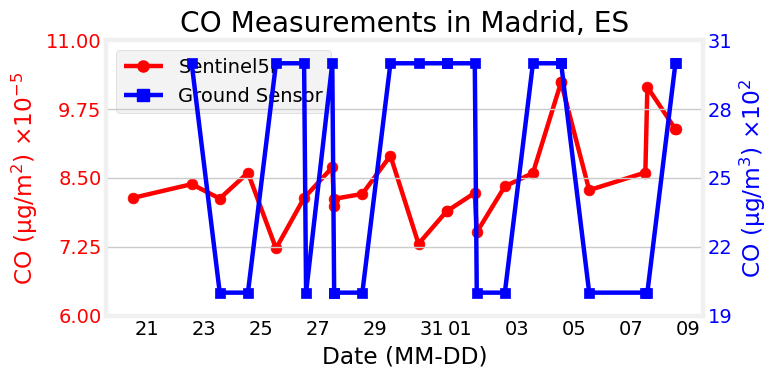

SPO-LU0101A_00010_100, 13    0.111911
Name: correlation, dtype: float64


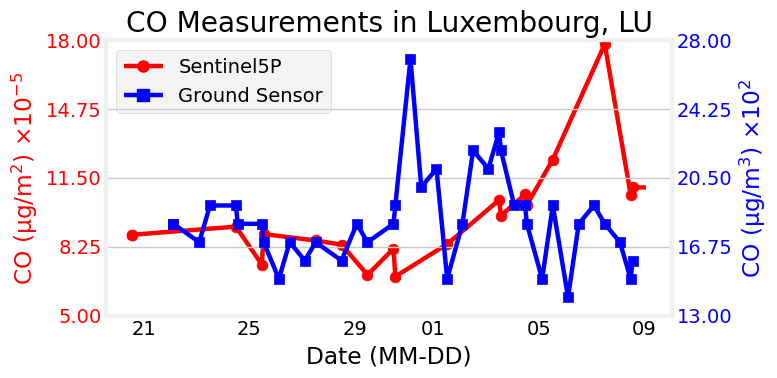

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

num_plot_sensors=10
for sensor_id in sensor_correlations['sensorID'].unique()[:num_plot_sensors]:
    sensor_df = merged_data[merged_data['sensorID'] == sensor_id]
    print(f"{sensor_id}, {sensor_correlations.loc[sensor_correlations['sensorID']==sensor_id, 'correlation']}")
    

    city_country = ', '.join(valid_sampling_data.loc[valid_sampling_data['Sampling station ID'] == sensor_id, ['city', 'country']].values[0])
    fig, ax1 = plt.subplots(figsize=(8, 4))
    plt.style.use("fivethirtyeight")

    # Remove grid lines
    ax1.grid(False)
    
    # ---- Scale factor ----
    scale_factor_left = 1e-5
    scale_factor_right = 1e2

    # ---- Left y-axis (Sentinel5P) ----
    ax1.scatter(sensor_df['timestamp'], sensor_df['copernicus_CO'] * scale_factor_left, color='red', s=60)
    ax1.plot(sensor_df['timestamp'], sensor_df['interp_copernicus_CO'] * scale_factor_left, color='red', label='Sentinel5P', linewidth=3.2)
    ax1.set_xlabel('Date (MM-DD)')
    ax1.set_ylabel(r'CO (μg/m$^2$) $\times 10^{-5}$', color='red')  # ← updated label
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.set_ylim(int(np.min(sensor_df['copernicus_CO']) * scale_factor_left)-1, 
                 int(np.max(sensor_df['copernicus_CO']) * scale_factor_left)+1)
    ax1.set_yticks(np.linspace(int(np.min(sensor_df['copernicus_CO']) * scale_factor_left)-1,
                               int(np.max(sensor_df['copernicus_CO']) * scale_factor_left)+1, 5))

    # ---- Right y-axis (Ground Sensor) ----
    ax2 = ax1.twinx()
    ax2.scatter(sensor_df['timestamp'], sensor_df['sensor_CO'] * scale_factor_right, color='blue', marker='s', s=60)
    ax2.plot(sensor_df['timestamp'], sensor_df['sensor_CO'] * scale_factor_right, color='blue', label='Ground Sensor', linewidth=3.2)
    ax2.set_ylabel(r'CO (μg/m$^3$) $\times 10^2$', color='blue')  # ← updated label
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.set_ylim(int(np.min(sensor_df['sensor_CO']) * scale_factor_right)-1,
                 np.max(sensor_df['sensor_CO']) * scale_factor_right)
    ax2.set_yticks(np.linspace(int(np.min(sensor_df['sensor_CO']) * scale_factor_right)-1, 
                               int(np.max(sensor_df['sensor_CO']) * scale_factor_right)+1, 5))

    # Title and legend
    plt.title(f'CO Measurements in {city_country}')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d'))

    legend_elements = [
    Line2D([0], [0], color='red', marker='o', linestyle='-', linewidth=3.2, markersize=8, label='Sentinel5P'),
    Line2D([0], [0], color='blue', marker='s', linestyle='-', linewidth=3.2, markersize=8, label='Ground Sensor')
    ]

    ax1.legend(handles=legend_elements, loc='upper left')
    fig.patch.set_facecolor('white')
    ax1.set_facecolor('white')

    plt.tight_layout()
    plt.show()